In [1]:
!pip install opencv-python opencv-python-headless



In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
cv_ass3='/content/drive/MyDrive/cv ass3'

In [23]:
import os
images = [os.path.join(cv_ass3, file) for file in os.listdir(cv_ass3) if os.path.isfile(os.path.join(cv_ass3, file))]


In [24]:
images.sort()
print(images)

['/content/drive/MyDrive/cv ass3/1.jpg', '/content/drive/MyDrive/cv ass3/2.jpg', '/content/drive/MyDrive/cv ass3/3.jpg', '/content/drive/MyDrive/cv ass3/4.jpg', '/content/drive/MyDrive/cv ass3/5.jpg', '/content/drive/MyDrive/cv ass3/6.jpg', '/content/drive/MyDrive/cv ass3/7.jpg', '/content/drive/MyDrive/cv ass3/8.jpg']


#1. Extarct keypoints and descriptors with SIFT

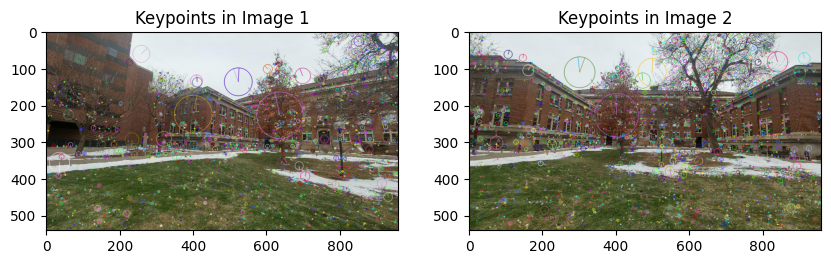

In [6]:
import cv2
import matplotlib.pyplot as plt


image1 = cv2.imread(images[0])
image2 = cv2.imread(images[1])


gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)


sift = cv2.SIFT_create()


keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)


image1_keypoints = cv2.drawKeypoints(image1, keypoints1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
image2_keypoints = cv2.drawKeypoints(image2, keypoints2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image1_keypoints, cv2.COLOR_BGR2RGB))
plt.title('Keypoints in Image 1')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image2_keypoints, cv2.COLOR_BGR2RGB))
plt.title('Keypoints in Image 2')

plt.show()



#2. Matching Extracted Features with  1. BruteForce 2. FlannBased

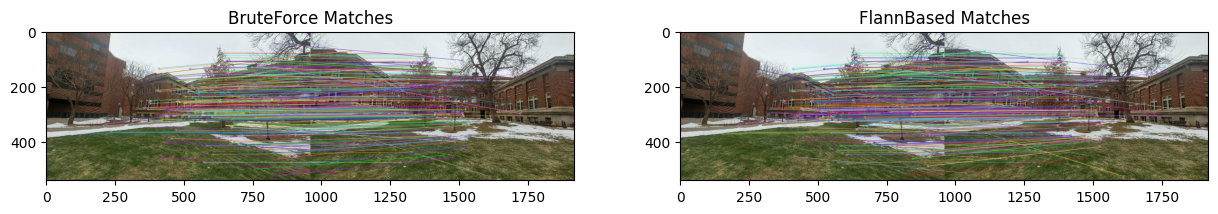

In [7]:
#BRUTE FORCE
bf = cv2.BFMatcher()
matches_bf = bf.knnMatch(descriptors1, descriptors2, k=2)


good_matches_bf = []
for m, n in matches_bf:
    if m.distance < 0.75 * n.distance:
        good_matches_bf.append([m])


bf_img_matches = cv2.drawMatchesKnn(image1, keypoints1, image2, keypoints2, good_matches_bf, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

#FLANBASED ALGO
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches_flann = flann.knnMatch(descriptors1, descriptors2, k=2)


good_matches_flann = []
for m, n in matches_flann:
    if m.distance < 0.75 * n.distance:
        good_matches_flann.append([m])


flann_img_matches = cv2.drawMatchesKnn(image1, keypoints1, image2, keypoints2, good_matches_flann, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(bf_img_matches, cv2.COLOR_BGR2RGB))
plt.title('BruteForce Matches')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(flann_img_matches, cv2.COLOR_BGR2RGB))
plt.title('FlannBased Matches')

plt.show()



#3. Compute Homography Matrix using RANSAC

In [8]:
import numpy as np

In [9]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC)

print("Computed H matrix with RANSAC Algo")
print(H)



Computed H matrix with RANSAC Algo
[[-1.79925632e-02 -1.82101286e-02  3.65665156e+02]
 [-3.06364592e-01  5.68856637e-01  1.27080897e+02]
 [-1.02176144e-03 -8.13376809e-05  1.00000000e+00]]


#4. Perspective Warping Image 2 w.r.t to Image 1

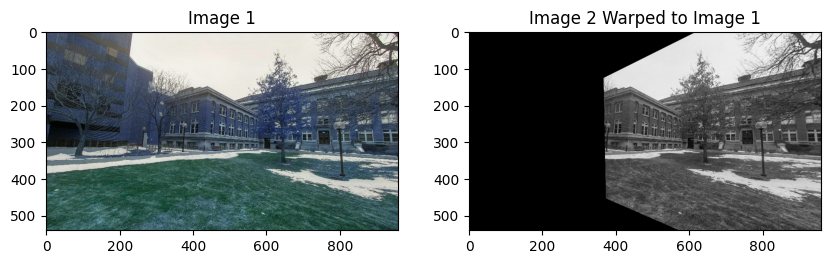

In [10]:
height, width = gray1.shape
image2_warped = cv2.warpPerspective(gray2, H, (width, height))

image2_warped=cv2.cvtColor(image2_warped,cv2.COLOR_BGR2RGB)


plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(image1)
plt.title('Image 1')
plt.subplot(122)
plt.imshow(image2_warped)
plt.title('Image 2 Warped to Image 1')
plt.show()


#5. Displaying the panaromas

1. Without cropping and blending

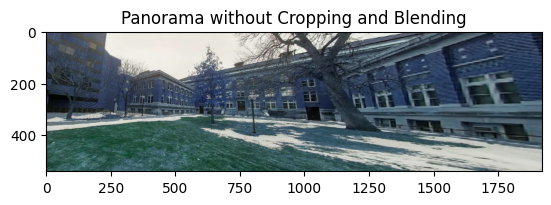

In [18]:
height, width, channels = image1.shape
panorama = cv2.warpPerspective(image2, H, (width*2, height))

# Copy the first image into the start of the panorama
panorama[0:height, 0:width] = image1

# Display the panorama without cropping and blending
plt.imshow(panorama)
plt.title("Panorama without Cropping and Blending")
plt.show()

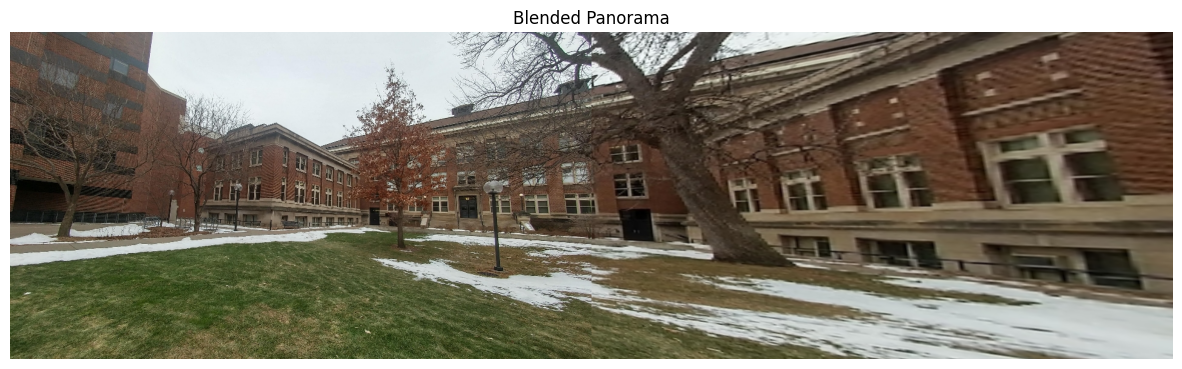

In [20]:
width_panorama = image1.shape[1] + image2.shape[1]
height_panorama = image1.shape[0]
panorama = cv2.warpPerspective(image2, H, (width_panorama, height_panorama))
panorama[0:image1.shape[0], 0:image1.shape[1]] = image1




overlap = 100
for i in range(overlap):
    alpha = i / overlap
    panorama[:image1.shape[0], image1.shape[1] - overlap + i] = (1 - alpha) * panorama[:image1.shape[0], image1.shape[1] - overlap + i] + alpha * image1[:image1.shape[0], image1.shape[1] - overlap + i]


plt.figure(figsize=(15, 7))
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.title('Blended Panorama')
plt.axis('off')
plt.show()


#5. STITCHING all images in the folder

Created function as per the hint

In [13]:
def stitch_images(image1, image2):


    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)


    sift = cv2.SIFT_create()

    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)


    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(descriptors1, descriptors2, k=2)


    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    H, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC)

    width_panorama = image1.shape[1] + image2.shape[1]
    height_panorama = image1.shape[0]
    panorama = cv2.warpPerspective(image2, H, (width_panorama, height_panorama))
    panorama[0:image1.shape[0], 0:image1.shape[1]] = image1
    return panorama

Used inbuilt CV2 stitcher function

In [14]:
panoramas=[cv2.imread(image) for image in images]


In [15]:
stitcher = cv2.Stitcher.create(cv2.Stitcher_PANORAMA)

status, stitched_image = stitcher.stitch(panoramas)

Panorama Generated


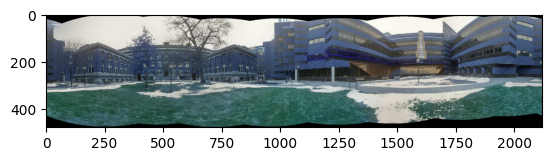

In [16]:

print('Panorama Generated')
plt.imshow( stitched_image)


In [25]:
images_store=images

In [34]:
images=images_store